In [1]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import helper_libraries.results_tools as results_tools
import multiprocessing
import functools
import warnings
from tqdm.auto import tqdm

warnings.simplefilter("ignore")

# Import data

## BBG data

In [2]:
bbg_df = pd.read_stata('../../data/calendars/bbg_96_18_econrelease.dta')
bbg_df

,Date,Time,Country,Event,Ticker,Period,Relevance,Survey,Actual,Prior,Revised,Units
0,1996-10-31,08:30,US,Personal Income,PITLCHNG Index,Sep,85.71430,0.006,0.006,0.006,NaN,
1,1996-10-31,08:30,US,US Personal Outlays SA,PIDSSO Index,Sep,0.00000,0.003,0.001,0.006,NaN,
2,1996-11-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Oct,96.03170,50.900,50.200,51.700,NaN,
3,1996-11-01,10:00,US,Factory Orders,TMNOCHNG Index,Sep,87.30160,0.027,0.027,-0.019,NaN,
4,1996-11-04,10:00,US,Construction Spending,VNCCTOT Index,Sep,0.00000,-0.100,-1.100,0.900,NaN,$
...,...,...,...,...,...,...,...,...,...,...,...,...
24681,2018-12-28,10:00,US,Pending Home Sales NSA YoY,USPHTYOY Index,Nov,28.34650,NaN,NaN,NaN,NaN,
24682,2018-12-28,08:30,US,Advance Goods Trade Balance,USTGTTCB Index,Nov,7.08661,NaN,NaN,NaN,NaN,
24683,2018-12-28,08:30,US,Retail Inventories MoM,RSRSTMOM Index,Nov,3.93701,NaN,NaN,NaN,NaN,
24684,2018-12-31,09:45,US,Chicago Purchasing Manager,CHPMINDX Index,Dec,81.88980,NaN,NaN,NaN,NaN,


## Returns and Spreads

In [3]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

## Trading

In [4]:
# Year to start trading
start_year = '2004'

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = [
    "Benchmark",
    "LR",
    "LR_PCA_select",
    "LR_Lasso_select",
    "Lasso",
    "Enet"
]

In [5]:
# Load model results
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    overnight=False,
    oos_periods=2,
    predictors="All",
    debug=True,
)

# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=True,
)

Loading the following model results...
--------------------------------------------------
Folder           main
Overnight       False
OOSPeriods          2
Predictors        All
Notes            Done
Asset         ff__mkt
--------------------------------------------------


# Analysis

In [6]:
# Define data
trading_returns_df = oss_returns_all_df.copy()
predicted_returns_df = oss_retpred_all_df.copy()

In [7]:
# Plotting function
def plot_results(plot_df, fig, ax, y, ylabel, strategy, add_zero_line = True, use_percent_formatting = True):
    sns.lineplot(
        x="time",
        y=y,
        hue="model",
        palette="Set2",
        data=plot_df.reset_index(),
        ax = ax
    )
    sns.scatterplot(
        x="time",
        y=y,
        hue="model",
        palette="Set2",
        data=plot_df.reset_index(),
        legend=False,
        ax = ax
    )
    ax.set_title(strategy)
    ax.set_xlabel('Time')
    ax.set_ylabel(None)
    ax.grid(alpha = 0.1, axis = 'x')
    ax.get_legend().set_title('Model')
    
    if use_percent_formatting:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 2))

    if add_zero_line:
        ax.axhline(0, color = 'k', ls = '--', alpha = 0.5)
    
    if strategy != 'Market':
        ax.get_legend().remove()

## Average Returns for various Days

In [8]:
plot_df = trading_returns_df.copy()
plot_df[('Enet', 'MS Strategy 1 (Difference)')] = plot_df['Enet']['MS Strategy 1'] - plot_df['Enet']['Market']
plot_df.index = pd.to_datetime(plot_df.index)
plot_df['Date'] = pd.to_datetime(plot_df.index.date)

In [9]:
bbg_dates_fomc = bbg_df.query('Event.str.contains("FOMC")', engine = 'python')['Date'].to_list()
bbg_dates_cconf = bbg_df.query('Ticker.str.contains("CONCCONF ")', engine = 'python')['Date'].to_list()
bbg_dates_manu = bbg_df.query('Ticker.str.contains("NAPMPMI ")', engine = 'python')['Date'].to_list()
bbg_dates_inf510 = bbg_df.query('Ticker.str.contains("CONSP5MD ")', engine = 'python')['Date'].to_list()

In [10]:
def get_trading_results_model_strategy(plot_df, model, strategy):
    
    # Get trading results
    strategy_results = plot_df[model][strategy].to_frame(pair_name).dropna()
    strategy_results["time"] = pd.Categorical(
        strategy_results.index.strftime("%H:%M").astype(str),
    )
    strategy_results_mean = strategy_results.set_index("time").groupby(level=0).mean()
    strategy_results_vol = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum().pipe(np.sqrt)
    ) / strategy_results.set_index("time").groupby(level=0).count()
    
    return strategy_results_mean, strategy_results_vol

def add_return_plot(strategy_results_mean, strategy_results_vol, color, ax):
    sns.pointplot(
        x="time",
        y=pair_name,
        data=strategy_results_mean.reset_index(),
        ci=None,
        color=color,
        lw=2,
        ax=ax,
        scale=0.75,
    )
    ax.fill_between(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
    )
    ax.plot(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
        ls = '--',
    )
    

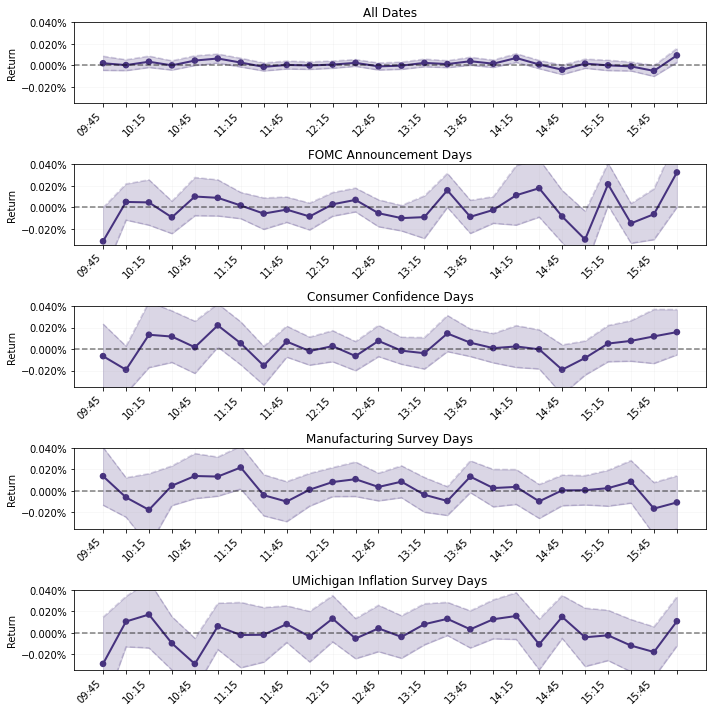

In [12]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=5)

# Get model/strat
model, strategy = ("Enet", "MS Strategy 1 (Difference)")
pair_name = f"{model} - {strategy}"

# Plot
idx = 0
ax = axs.reshape(-1)[0]
strategy_results_mean, strategy_results_vol = get_trading_results_model_strategy(
    plot_df, model, strategy
)
color = sns.color_palette("viridis", 6)[idx]
add_return_plot(strategy_results_mean, strategy_results_vol, color, ax)
ax.set_title('All Dates')

# Plot
ax = axs.reshape(-1)[1]
strategy_results_mean, strategy_results_vol = get_trading_results_model_strategy(
    plot_df.loc[plot_df["Date"].apply(lambda x: x in bbg_dates_fomc)], model, strategy
)
color = sns.color_palette("viridis", 6)[idx]
add_return_plot(strategy_results_mean, strategy_results_vol, color, ax)
ax.set_title('FOMC Announcement Days')

# Plot
ax = axs.reshape(-1)[2]
strategy_results_mean, strategy_results_vol = get_trading_results_model_strategy(
    plot_df.loc[plot_df["Date"].apply(lambda x: x in bbg_dates_cconf)], model, strategy
)
color = sns.color_palette("viridis", 6)[idx]
add_return_plot(strategy_results_mean, strategy_results_vol, color, ax)
ax.set_title('Consumer Confidence Days')

# Plot
ax = axs.reshape(-1)[3]
strategy_results_mean, strategy_results_vol = get_trading_results_model_strategy(
    plot_df.loc[plot_df["Date"].apply(lambda x: x in bbg_dates_manu)], model, strategy
)
color = sns.color_palette("viridis", 6)[idx]
add_return_plot(strategy_results_mean, strategy_results_vol, color, ax)
ax.set_title('Manufacturing Survey Days')

# Plot
ax = axs.reshape(-1)[4]
strategy_results_mean, strategy_results_vol = get_trading_results_model_strategy(
    plot_df.loc[plot_df["Date"].apply(lambda x: x in bbg_dates_inf510)], model, strategy
)
color = sns.color_palette("viridis", 6)[idx]
add_return_plot(strategy_results_mean, strategy_results_vol, color, ax)
ax.set_title('UMichigan Inflation Survey Days')


for ax in axs.reshape(-1):
    ax.axhline(0, color="k", ls="--", alpha=0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if idx % 2 == 0:
        ax.set_ylabel("Return")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=3))
    [l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
    ax.set_ylim(-0.00035, 0.0004)
    ax.grid(alpha=0.1)

plt.tight_layout()

## Stats

In [62]:
# Get strategy returns
strategy_results = plot_df[model][strategy].to_frame(pair_name).dropna()
strategy_results["time"] = pd.Categorical(
    strategy_results.index.strftime("%H:%M").astype(str),
)
strategy_results['date']= strategy_results.index.date

In [63]:
# Get rounded datetimes
bbg_df['datetime'] = pd.to_datetime(bbg_df['Date'].astype(str) + ' ' + bbg_df['Time'], format = '%Y-%m-%d %H:%M', errors = 'coerce')
bbg_df['datetime_rounded'] = bbg_df['datetime'].dt.ceil('15min')
# bbg_df.query('Event.str.contains("FOMC")', engine = 'python')['

In [64]:
bbg_dates_fomc = bbg_df.query('Event.str.contains("FOMC")', engine = 'python')['Date'].to_list()
bbg_dates_cconf = bbg_df.query('Ticker.str.contains("CONCCONF ")', engine = 'python')['Date'].to_list()
bbg_dates_manu = bbg_df.query('Ticker.str.contains("NAPMPMI ")', engine = 'python')['Date'].to_list()
bbg_dates_inf510 = bbg_df.query('Ticker.str.contains("CONSP5MD ")', engine = 'python')['Date'].to_list()

In [65]:
def add_event_indicator(name, query_str):

    strategy_results[f"ind_{name}"] = 0
    strategy_results.loc[
        set(strategy_results.index).intersection(
            bbg_df.query(query_str, engine="python")["datetime_rounded"]
        ),
        f"ind_{name}",
    ] = 1
    strategy_results[f'ind_{name}_lag'] = strategy_results[f'ind_{name}'].shift(1).fillna(0)

add_event_indicator('fomc',   'Event.str.contains("FOMC")')
add_event_indicator('cconf',   'Ticker.str.contains("CONCCONF ")')
add_event_indicator('manu',   'Ticker.str.contains("NAPMPMI ")')
add_event_indicator('inf510',   'Ticker.str.contains("CONSP5MD ")')

strategy_results['ms_return'] = strategy_results[pair_name]
strategy_results

,Enet - MS Strategy 1 (Difference),time,date,ind_fomc,ind_fomc_lag,ind_cconf,ind_cconf_lag,ind_manu,ind_manu_lag,ind_inf510,ind_inf510_lag,ms_return
datetime,,,,,,,,,,,,
2004-01-02 09:45:00,0.000000,09:45,2004-01-02,0,0.0,0,0.0,0,0.0,0,0.0,0.000000
2004-01-02 10:00:00,0.000880,10:00,2004-01-02,0,0.0,0,0.0,1,0.0,0,0.0,0.000880
2004-01-02 10:15:00,-0.002169,10:15,2004-01-02,0,0.0,0,0.0,0,1.0,0,0.0,-0.002169
2004-01-02 10:30:00,0.000205,10:30,2004-01-02,0,0.0,0,0.0,0,0.0,0,0.0,0.000205
2004-01-02 10:45:00,0.000047,10:45,2004-01-02,0,0.0,0,0.0,0,0.0,0,0.0,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 15:00:00,0.000660,15:00,2020-12-31,0,0.0,0,0.0,0,0.0,0,0.0,0.000660
2020-12-31 15:15:00,-0.001633,15:15,2020-12-31,0,0.0,0,0.0,0,0.0,0,0.0,-0.001633
2020-12-31 15:30:00,0.000421,15:30,2020-12-31,0,0.0,0,0.0,0,0.0,0,0.0,0.000421


In [66]:
smf.ols(f"ms_return ~ 1 + ind_fomc + ind_cconf + ind_manu + ind_inf510", strategy_results).fit(
    cov_type="HAC", cov_kwds={"maxlags": 90}
).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ms_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.192
Date:                Wed, 09 Mar 2022   Prob (F-statistic):              0.312
Time:                        16:40:46   Log-Likelihood:             5.7044e+05
No. Observations:              111079   AIC:                        -1.141e+06
Df Residuals:                  111074   BIC:                        -1.141e+06
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.509e-05   4.29e-06      3.515      0.000    6.67e-06    2.35e-05
ind_fomc    7.787e-06   8.93e-05      0.087      0.931      -0.000       0.000
ind_cconf     -0.0002      0.000     -1.857      0.063      -0.000    1.14e-05
ind_manu   -7.542e-05   9.32e-05     -0.809      0.418      -0.000       0.000
ind_inf510  9.176e-05      0.000      0.770      0.441      -0.000       0.000
==============================================================================
Omnibus:                    36396.060   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10847577.578
Skew:                           0.022   Prob(JB):                         0.00
Kurtosis:                      51.412   Cond. No.                         34.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 90 lags and without small sample correction
"""

In [67]:
smf.ols(
    f"ms_return ~ 1 + ind_fomc_lag + ind_cconf_lag + ind_manu_lag + ind_inf510_lag",
    strategy_results,
).fit(cov_type="HAC", cov_kwds={"maxlags": 90}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ms_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.079
Date:                Wed, 09 Mar 2022   Prob (F-statistic):              0.365
Time:                        16:40:46   Log-Likelihood:             5.7044e+05
No. Observations:              111079   AIC:                        -1.141e+06
Df Residuals:                  111074   BIC:                        -1.141e+06
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.431e-05   4.26e-06      3.363      0.001    5.97e-06    2.27e-05
ind_fomc_lag       0.0002      0.000      1.092      0.275      -0.000       0.001
ind_cconf_lag      0.0001      0.000      0.774      0.439      -0.000       0.000
ind_manu_lag      -0.0002      0.000     -1.129      0.259      -0.001       0.000
ind_inf510_lag     0.0002      0.000      1.029      0.304      -0.000       0.000
==============================================================================
Omnibus:                    36391.953   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10841125.107
Skew:                           0.021   Prob(JB):                         0.00
Kurtosis:                      51.398   Cond. No.                         34.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 90 lags and without small sample correction
"""